# 유전 알고리즘을 통한 Decision Tree 변수 선택법 실습
---
본 노트북 파일은 고려대학교 산업경영공학부 강필성 교수님의 대학원 수업인 Business Analytics 수업 내용 중 Genetic Algoritm을 담고 있습니다. \
본 노트북 파일의 목표는 다음과 같습니다. 
- 실제 구현을 통하여 구체적인 알고리즘의 동작 방식을 파악한다.
- 다양한 하이퍼 파라미터 실험을 통하여 변수 선택에 있어 각 요소의 영향력을 파악한다. 

In [74]:
import torch
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.datasets import load_wine
import pandas as pd 
from tqdm.auto import tqdm
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

## 1. dataset 
- Wine Dataset
- 데이터셋에 대한 자세한 설명은 다음과 같습니다. 
Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
        - 1) Alcohol
        - 2) Malic acid
        - 3) Ash
        - 4) Alcalinity of ash  
        - 5) Magnesium
        - 6) Total phenols
        - 7) Flavanoids
        - 8) Nonflavanoid phenols
        - 9) Proanthocyanins
        - 10)Color intensity
        - 11)Hue
        - 12)OD280/OD315 of diluted wines
        - 13)Proline
            - class:
                - class_0
                - class_1
                - class_2

    :Summary Statistics:

    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Magnesium:                    70.0 162.0    99.7  14.3
    Total Phenols:                0.98  3.88    2.29  0.63
    Flavanoids:                   0.34  5.08    2.03  1.00
    Nonflavanoid Phenols:         0.13  0.66    0.36  0.12
    Proanthocyanins:              0.41  3.58    1.59  0.57
    Colour Intensity:              1.3  13.0     5.1   2.3
    Hue:                          0.48  1.71    0.96  0.23
    OD280/OD315 of diluted wines: 1.27  4.00    2.61  0.71
    Proline:                       278  1680     746   315
    ============================= ==== ===== ======= =====

    :Missing Attribute Values: None
    :Class Distribution: class_0 (59), class_1 (71), class_2 (48)
    :Creator: R.A. Fisher
    :Donor: Michael Marshall (MARSHALL%PLU@io.arc.nasa.gov)
    :Date: July, 1988

This is a copy of UCI ML Wine recognition datasets.
https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

The data is the results of a chemical analysis of wines grown in the same
region in Italy by three different cultivators. There are thirteen different
measurements taken for different constituents found in the three types of
wine.

Original Owners: 

Forina, M. et al, PARVUS - 
An Extendible Package for Data Exploration, Classification and Correlation. 
Institute of Pharmaceutical and Food Analysis and Technologies,
Via Brigata Salerno, 16147 Genoa, Italy.

Citation:

Lichman, M. (2013). UCI Machine Learning Repository
[http://archive.ics.uci.edu/ml]. Irvine, CA: University of California,
School of Information and Computer Science. 

References
----------
(1) 
S. Aeberhard, D. Coomans and O. de Vel, 
Comparison of Classifiers in High Dimensional Settings, 
Tech. Rep. no. 92-02, (1992), Dept. of Computer Science and Dept. of 
Mathematics and Statistics, James Cook University of North Queensland. 
(Also submitted to Technometrics). 

The data was used with many others for comparing various 
classifiers. The classes are separable, though only RDA 
has achieved 100% correct classification. 
(RDA : 100%, QDA 99.4%, LDA 98.9%, 1NN 96.1% (z-transformed data)) 
(All results using the leave-one-out technique) 

(2) 
S. Aeberhard, D. Coomans and O. de Vel, 
"THE CLASSIFICATION PERFORMANCE OF RDA" 
Tech. Rep. no. 92-01, (1992), Dept. of Computer Science and Dept. of 
Mathematics and Statistics, James Cook University of North Queensland. 
(Also submitted to Journal of Chemometrics). 
'''

---
본 데이터셋은 색, 향, 도수 등 다양한 요소를 이용하여 실제 와인의 등급을 예측하는 태스크입니다. 모두 수치형 데이터로 구성되어 있으며, 각 요소들이 독립적이지 않고 상관관계를 가지고 있기 때문에, 모든 변수를 사용하는 것이 최선의 조합이 아닙니다. 하지만 13개 변수에 대해 모든 조합을 탐색하는 것은 매우 시간이 많이 소모되므로 Genetic Algoritm을 통하여 효율적인 탐색이 가능합니다. 

In [107]:
data = load_wine()

## 2. Genetic Algorithm
유전 알고리즘에 대해 설명하겠습니다. 우선 유전 알고리즘에서 고려해야 하는 하이퍼파라미터는 다음과 같습니다. 
- 하이퍼파라미터 
    - 최대 세대 수 : 세대 반복의 횟수
    - population : 한 세대 내 chromosome 수
    - mutation rate : 다음 세대로 넘어가기 직전, 유전자 돌연변이 비율
    - select method (top, prob) : 적합도 함수를 기반으로 생존할 chromosome을 정하는 방법론
    - select top k : top 방법론을 사용할 때, 적합도 함수 기반 생존할 상위 chromosome 수
    - fitness function : 세대 내 chromosome들을 평가하기 위해 사용할 함수 (본 실습에서는 정확도로 고정합니다.) 

---
- 유전 알고리즘 개요 
유전 알고리즘의 진행 순서는 다음과 같습니다.
    1. 염색체 초기화 
    2. 염색체 별 모델 학습
    3. 염색체 별 적합도 평가
    4. 우수 염색체 선택
    5. 다음 염색체 생성(Cross Over & Mutation)
    6. 최종 변수 선택

In [108]:
class GeneticAlgoritm() :
    def __init__(self, args) :
        self.args = args
        self.population_size = args.population_size
        self.max_generation = args.max_generation
        self.mutation_rate = args.mutation_rate
        self.dataset_X = args.dataset.data
        self.dataset_Y = args.dataset.target

        self.num_variable = self.dataset_X.shape[1]
        self.num_class = len(set(self.dataset_Y))

        self.model_initilizer = args.model_initilizer
        
        self.fitness_score_log = {}
        
    def fit(self) :
        # 1. 염색체 초기화
        cur_population = torch.randint(low=0, high=2, size=(self.population_size, self.dataset_X.shape[1]))
        for generation in tqdm(range(self.max_generation)) :
            # 2. 염색체 별 모델 학습 및 적합도 평가 
            fitness_score = self.test_population(self.dataset_X, self.dataset_Y, cur_population)
            # 3. 우수 염색체 선택
            survived_population = self.select_chromosome(cur_population, fitness_score)
            # 4. 염색체 교차
            crossed_population = self.crossover(survived_population)
            # 5. 염색체 돌연변이
            cur_population = self.mutation(crossed_population)

            self.fitness_score_log[generation] = fitness_score.mean().item()
        return cur_population, fitness_score

    def test_population(self, X, y, population) :
        test_score = []
        for pop in population :
            if sum(pop) == 0:
                test_score.append(0) # 변수를 전혀 사용하지 않는 유전자는 적합도 함수에 대해 0점을 부여하게 됩니다. 
            else :
                pop_X = X[:, pop==1]
                test_score.append(self.test_chromosome(pop_X, y)) # 각 chromosome에 대해 적합도를 판단하고 저장하게 됩니다. 
        return torch.tensor(test_score)
    
    def select_chromosome(self, population, fitness_score) : # 산출된 fitness score를 기반으로 염색체를 선택합니다.
        if self.args.select_method == "top" :
            return self.select_chromosome_top(population, fitness_score)
        elif self.args.select_method == "prob" :
            return self.select_chromosome_prob(population, fitness_score)

    def crossover(self, survived_population) :
        crossed_population = []
        num_crossover = self.args.population_size - len(survived_population) # Cross Over를 통해 새로 만들어질 chromosome 수는 총 population size에서 우수 chromosome의 수를 뺀 값입니다. 즉, 세대가 지나도 Population Size는 유지됩니다. 
        
        slice_idxes = torch.randint(low=1, high=self.num_variable-1, size=(num_crossover, 1)) # 각 chromosome에 대해 랜덤한 유전자 위치에서 Cross Over가 발생하도록 합니다. 
        crossover_pop = torch.randint(low=0, high=len(survived_population), size=(num_crossover, 2))

        for slice_idx, (pop1, pop2) in zip(slice_idxes, crossover_pop) :
            crossed_population.append(torch.cat([survived_population[pop1, :slice_idx], survived_population[pop2, slice_idx:]]))

        return torch.cat([torch.stack(crossed_population), survived_population])

    def mutation(self, crossed_population) :
        mutation_idx = torch.rand(crossed_population.shape) < self.args.mutation_rate # 돌연변이는 전체 chromosome, 유전자에 대해 각각 독립적으로 발생합니다.
        crossed_population[mutation_idx] = 1 - crossed_population[mutation_idx]
        return crossed_population

    def test_chromosome(self, X, y) : # 적합도 함수를 통해 각 chromosome의 적합도를 판단합니다. 이때, 정확한 적합도를 판단하기 위해 K-Fold Cross Validation을 사용합니다.
        model = self.model_initilizer()
        kf = KFold(n_splits=5)
        test_score = []
        for train_idx, test_idx in kf.split(X):
            train_X, train_Y = X[train_idx], y[train_idx]
            test_X, test_Y = X[test_idx], y[test_idx]
            model = tree.DecisionTreeClassifier()
            model.fit(train_X, train_Y)
            model.score(test_X, test_Y)
            test_score.append(model.score(test_X, test_Y))
        return torch.tensor(test_score).mean()

    def select_chromosome_top(self, population, fitness_score) :
        return population[fitness_score.topk(self.args.select_top_k).indices.sort().values]

    def select_chromosome_prob(self, population, fitness_score) :
        chromosome_prob = fitness_score / fitness_score.sum()
        return population[torch.multinomial(chromosome_prob, self.args.select_top_k).sort().values]

## 3. 실험

### 3-1. Population 별 성능 비교

In [109]:
class Argument():
    def __init__(self) :
        self.population_size = 20
        self.max_generation = 30
        self.mutation_rate = 0.05
        self.select_method= "top"
        self.select_top_k = 5

        self.dataset = data
        self.model_initilizer = tree.DecisionTreeClassifier

        assert self.select_method in ["top", "prob"], "select method must be top, prob"
args = Argument()

100%|██████████| 30/30 [00:05<00:00,  5.20it/s]


<AxesSubplot:>

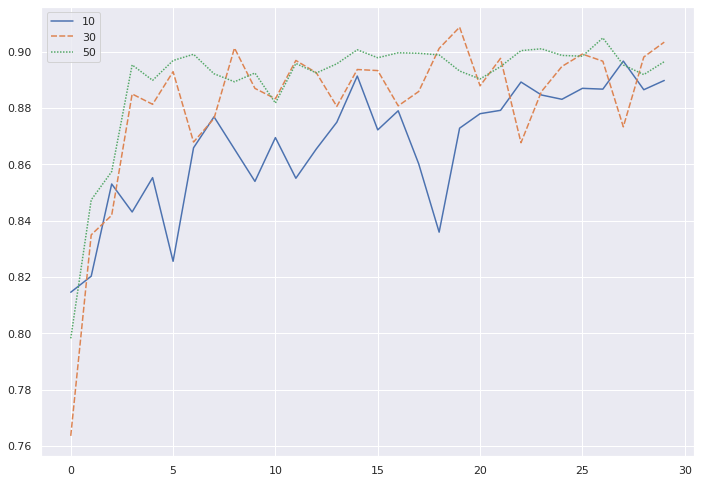

In [110]:
# 30 : 5초
# 50 : 9초
# 100 : 19초
best_result = {}
mean_result = {}
best_chromosome = {}
fitness_log = {}

for num_pop in [10, 30, 50] :
    args.population_size = num_pop
    ga = GeneticAlgoritm(args)
    population, fitness_score = ga.fit()
    fitness_log[num_pop] = ga.fitness_score_log
    best_result[num_pop] = fitness_score.max().item()
    mean_result[num_pop] = fitness_score.mean().item()
    best_chromosome[num_pop] = population[fitness_score.argmax()]
sns.lineplot(pd.DataFrame(fitness_log))

Population이 증가할 수록 빠르게 최고 성능에 가까워지는 것을 볼 수 있습니다. 이는 Population이 증가함에 따라 탐색 공간이 커지기 때문입니다. 즉, 탐색 공간이 증가하므로 국소적인 최적해를 빠르게 탐색하게 됩니다. 

In [62]:
pd.DataFrame({"num of population" : {key: key for key in best_result.keys()}, "best": best_result, "mean": mean_result})

,num of population,best,mean
10,10,0.926984,0.904286
30,30,0.932857,0.888286
50,50,0.944127,0.899314


Population이 증가할수록 점차 최고 성능이 올라가는 것을 관찰할 수 있습니다. 이는 Population이 증가하면, 탐색하는 공간이 넓어지기 때문이라고 볼 수 있습니다. Population이 증가할수록 평균 성능이 증가하지 않는 경향이 보이는데, 이는 Population이 증가하면서 유전자의 다양성이 증가했기 때문입니다. 

### 3-2. 돌연변이 비율 별 성능 비교

100%|██████████| 30/30 [00:05<00:00,  5.32it/s]


<AxesSubplot:>

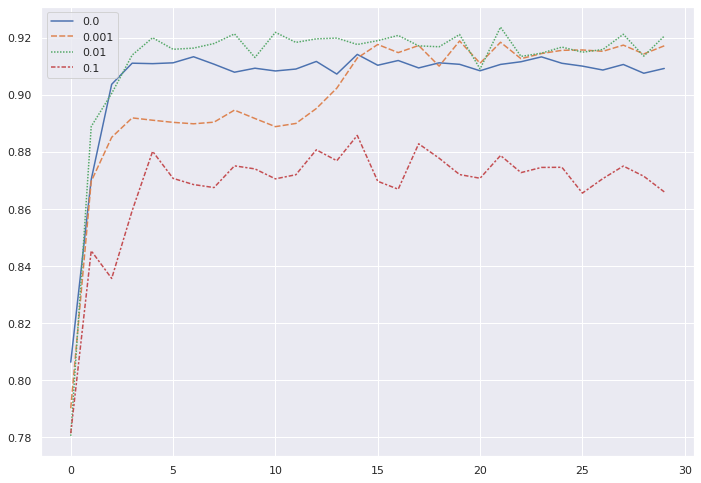

In [79]:
best_result = {}
mean_result = {}
best_chromosome = {}
fitness_log = {}

args = Argument()
args.population_size = 50 # 이전 실험에서 최고 성능을 보인 값 사용
# 30 : 5초
# 50 : 9초
# 100 : 19초
for mutation_rate in [0.001, 0.01, 0.1, 0] :
    args.mutation_rate = mutation_rate
    ga = GeneticAlgoritm(args)
    population, fitness_score = ga.fit()
    fitness_log[mutation_rate] = ga.fitness_score_log
    best_result[mutation_rate] = fitness_score.max().item()
    mean_result[mutation_rate] = fitness_score.mean().item()
    best_chromosome[mutation_rate] = population[fitness_score.argmax()]
sns.lineplot(pd.DataFrame(fitness_log))

돌연변이 비율이 늘어날수록 성능 편차가 점차 커지는 것을 알 수 있습니다. 특히 돌연변이 비율이 0.1과 같이 매우 높을 경우 돌연변이를 사용하지 않았을 때보다 매우 성능이 떨어지는 것을 관찰할 수 있습니다. 너무 높은 돌연변이 비율은 Genetic Algorithm을 통한 최적의 알고리즘 탐색에 방해가 된다는 것을 알 수 있습니다. 이는, 돌연변이로 인해 세대가 지나면서 가장 좋은 유전자의 경향성에 어긋나는 유전자가 발생하기 때문입니다. 하지만 무작정 낮은 돌연변이 비율이 좋은 것은 아닙니다. Decision Tree를 해당 데이터셋에 적용할 때, 돌연변이 비율을 0.01로 설정할 때, 0.001로 설정했을 때보다 성능이 좋은 것을 볼 수 있습니다. 이는 돌연변이를 통해 Local Minima에서 탈출하여 최적의 변수 조합에 가까운 변수를 탐색할 수 있기 때문입니다. 

In [80]:
pd.DataFrame({"Mutation Rate" : {key: key for key in best_result.keys()}, "best": best_result, "mean": mean_result})

,Mutation Rate,best,mean
0.001,0.001,0.932698,0.917190
0.010,0.010,0.944127,0.920603
0.100,0.100,0.938571,0.866022
0.000,0.000,0.927460,0.909263


각 돌연변이 비율 별 최고 성능을 살펴보더라도 동일한 경향을 관찰할 수 있습니다. 특히, 돌연변이 비율이 0.1일 경우 평균 성능이 비교적 낮은 것을 볼 수 있습니다. 이는 돌연변이 비율이 지나치게 높아지면 매 세대마다 전체 Population이 제대로 변수를 탐색하지 못하도록 방해하기 때문입니다.

### 3-3. 유전자 선택 방법 별 성능 비교

100%|██████████| 30/30 [00:06<00:00,  4.99it/s]


<AxesSubplot:>

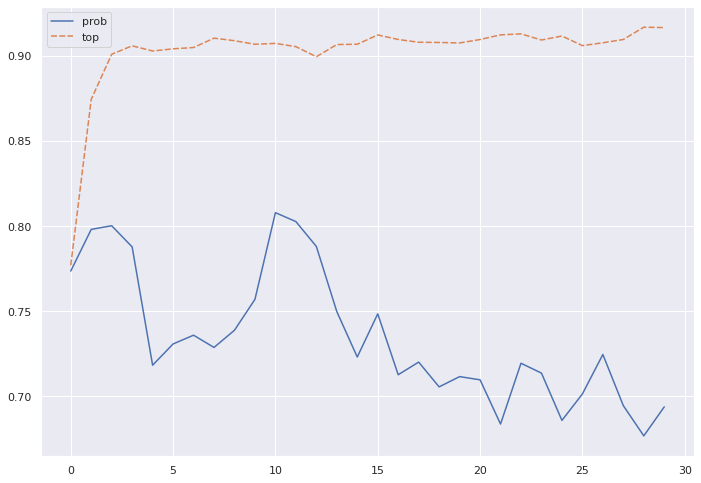

In [100]:
best_result = {}
mean_result = {}
best_chromosome = {}
fitness_log = {}

args = Argument()
args.population_size = 50 # 이전 실험에서 최고 성능을 보인 값 사용
args.mutation_rate = 0.01
# 30 : 5초
# 50 : 9초
# 100 : 19초
for select_method in ["prob", "top"] :
    args.select_method = select_method
    ga = GeneticAlgoritm(args)
    population, fitness_score = ga.fit()
    fitness_log[select_method] = ga.fitness_score_log
    best_result[select_method] = fitness_score.max().item()
    mean_result[select_method] = fitness_score.mean().item()
    best_chromosome[select_method] = population[fitness_score.argmax()]
sns.lineplot(pd.DataFrame(fitness_log))

In [101]:
pd.DataFrame({"Select Method" : {key: key for key in best_result.keys()}, "best": best_result, "mean": mean_result})

,Select Method,best,mean
prob,prob,0.847302,0.693863
top,top,0.944127,0.916590


전체 Population에서 어떤 유전자가 살아남을지 정하는 방법론에 따른 성능 비교 결과는 위와 같습니다. 그림에서 볼 수 있듯이, 전체 Population에서 Score에 비례하여 랜덤한 유전자를 선택하는 알고리즘은 매우 불안정하고, 최종 학습 성능이 좋지 못한 모습을 보이고 있습니다. 해당 태스크의 난이도가 높지 않고, 변수의 수가 많지 않아, 탐색할 공간의 크기가 넓지 않기 때문으로 추정됩니다. 